<a href="https://colab.research.google.com/github/Shoaibaqeel/Deep-Learning-Practice/blob/main/Assignment_2_Intel_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using the dataset provided at this link(https://www.kaggle.com/datasets/puneet6060/intel-image-classification), create a classifier to categorize images into six natural scene categories: The dataset consists of approximately 25,000 images, each of size 150x150 pixels, divided into training, testing, and prediction sets. Develop a model that effectively classifies the images, ensuring proper data preprocessing, training, validation, and evaluation. Additionally, assess the model's performance using metrics like accuracy, precision, recall, or F1-score, and provide insights into its effectiveness for this classification task.


**Step 1: Import Important libraries**

In [1]:
# Import Important libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
from keras.applications import VGG16
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

**Step 2: Load Data Set from the given source**

In [2]:
# Install the Kaggle Library
!pip install kaggle

# set Kagle API Key

os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!makdir -p `/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download data Set
!kaggle datasets download -d puneet6060/intel-image-classification

/bin/bash: -c: line 1: unexpected EOF while looking for matching ``'
/bin/bash: -c: line 2: syntax error: unexpected end of file
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
intel-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
# Extract dataset
import zipfile
dataset_zip = 'intel-image-classification.zip'
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall('/content')
print('Dataset extraction complete.')

Dataset extraction complete.


**Step 3: Define Dataset paths and Explore the Data Set**

In [4]:
# Define directories
train_dir = '/content/seg_train/seg_train'
test_dir = '/content/seg_test/seg_test'
pred_dir = '/content/seg_pred/seg_pred'

In [5]:
# Explore the dataset and view the categories
categories = os.listdir(train_dir)
print(f"categories: {categories}")

categories: ['street', 'mountain', 'buildings', 'glacier', 'forest', 'sea']


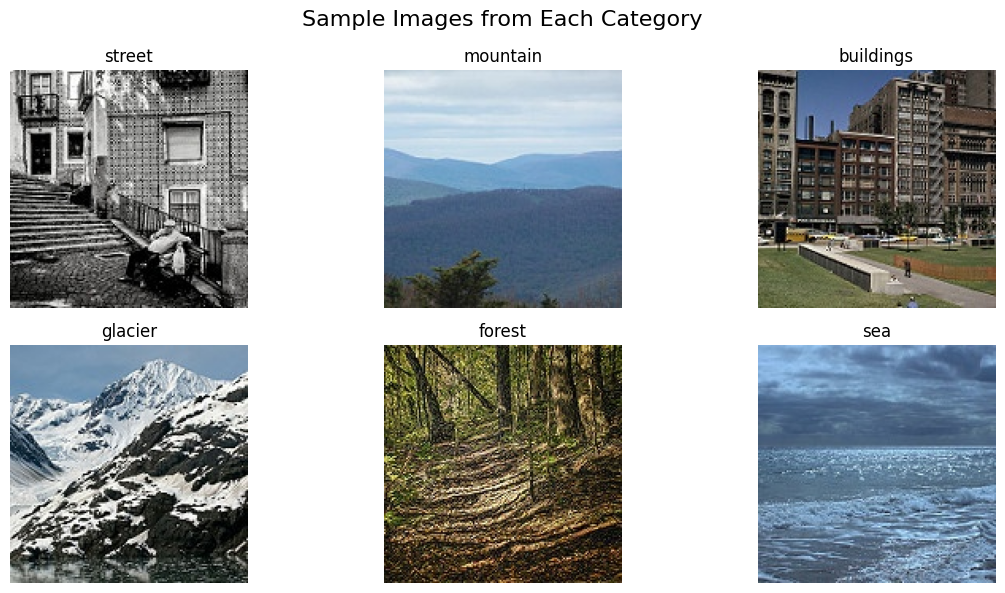

In [6]:
# Display image from each category

plt.figure(figsize=(12, 6))
for i, category in enumerate(categories[:6]):
    category_path = os.path.join(train_dir, category)
    image_name = os.listdir(category_path)[0]
    image_path = os.path.join(category_path, image_name)
    img = plt.imread(image_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(category)
    plt.axis('off')
plt.suptitle('Sample Images from Each Category', fontsize=16)
plt.tight_layout()

**Step 4: Data Preprocessing**

In [7]:
# Data Augmentation and Preprocessing

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)


In [8]:
# Load training and testing data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


**Build the Model with VGG16**

In [9]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
# Unfreeze Some Layers of VGG16

for layer in base_model.layers[:15]:  # Freeze the first 15 layers
    layer.trainable = False

for layer in base_model.layers[15:]:  # Unfreeze the last few layers
    layer.trainable = True

In [11]:
# Compile the Model
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Use a smaller learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,813,638 (64.14 MB)

 Trainable params: 9,178,374 (35.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [12]:
# Train the Model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs= 10
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


439/439 ━━━━━━━━━━━━━━━━━━━━ 127s 246ms/step - accuracy: 0.7430 - loss: 0.6879 - val_accuracy: 0.8937 - val_loss: 0.2992
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 118s 220ms/step - accuracy: 0.8835 - loss: 0.3298 - val_accuracy: 0.9037 - val_loss: 0.2869
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 98s 220ms/step - accuracy: 0.9042 - loss: 0.2706 - val_accuracy: 0.9110 - val_loss: 0.2538
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 100s 224ms/step - accuracy: 0.9170 - loss: 0.2369 - val_accuracy: 0.9150 - val_loss: 0.2516
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 138s 213ms/step - accuracy: 0.9280 - loss: 0.2030 - val_accuracy: 0.9020 - val_loss: 0.2845
Epoch 6/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 95s 215ms/step - accuracy: 0.9319 - loss: 0.1884 - val_accuracy: 0.9077 - val_loss: 0.2807
Epoch 7/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 148s 228ms/step - accuracy: 0.9414 - loss: 0.1612 - val_accuracy: 0.9123 - val_loss: 0.2831
Epoch 8/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 96s 217ms/step - accuracy: 0.9454 - loss: 0.1492 

In [13]:
# Evaluate the Model

print("Evaluating the model...")

# Evaluate on the training data
train_loss, train_acc = model.evaluate(train_generator, verbose=0)

# Evaluate on the test (validation) data
test_loss, test_acc = model.evaluate(test_generator, verbose=0)

# Print the evaluation results in a concise format
print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc*100:.2f}%")


Evaluating the model...
Training Loss: 0.0978, Training Accuracy: 96.49%
Test Loss: 0.3020, Test Accuracy: 90.33%


In [14]:
# Predict the test set and print additional details
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(labels, predicted_classes, target_names=class_labels))


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step

Classification Report:
              precision    recall  f1-score   support

   buildings       0.96      0.87      0.92       437
      forest       0.98      1.00      0.99       474
     glacier       0.77      0.91      0.84       553
    mountain       0.91      0.75      0.82       525
         sea       0.95      0.92      0.94       510
      street       0.90      0.97      0.93       501

    accuracy                           0.90      3000
   macro avg       0.91      0.90      0.91      3000
weighted avg       0.91      0.90      0.90      3000



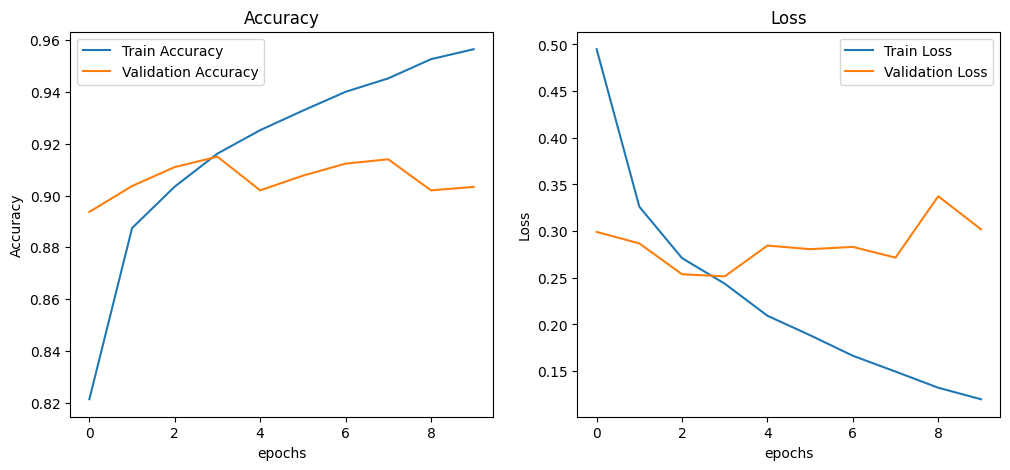

In [15]:
# Plot Training History

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()

plt.show()

In [16]:
print("Classification Report:")
print(classification_report(labels, predicted_classes, target_names=class_labels))

Classification Report:
              precision    recall  f1-score   support

   buildings       0.96      0.87      0.92       437
      forest       0.98      1.00      0.99       474
     glacier       0.77      0.91      0.84       553
    mountain       0.91      0.75      0.82       525
         sea       0.95      0.92      0.94       510
      street       0.90      0.97      0.93       501

    accuracy                           0.90      3000
   macro avg       0.91      0.90      0.91      3000
weighted avg       0.91      0.90      0.90      3000



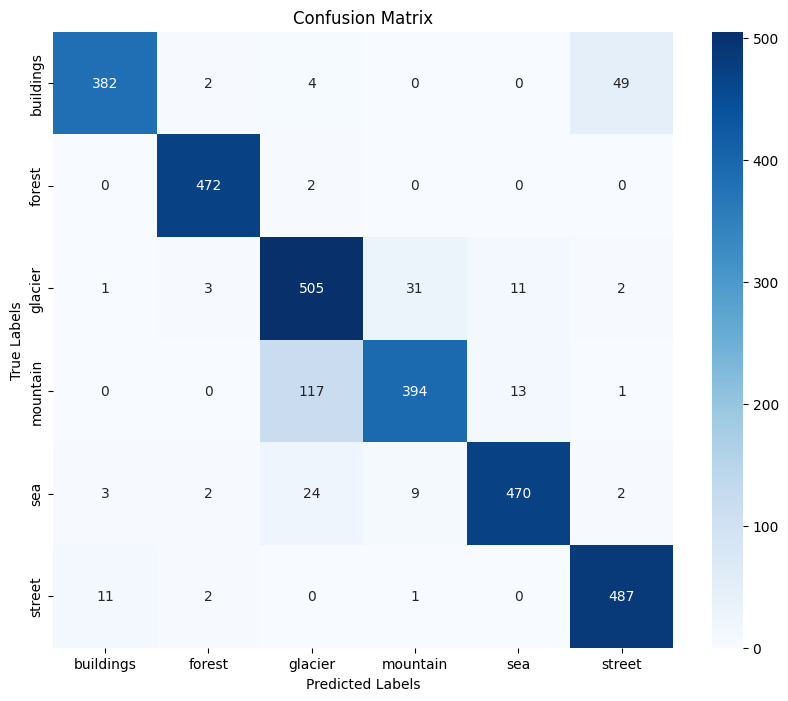

In [17]:
conf_matrix = confusion_matrix(labels, predicted_classes)

# Visualize the confusion matrix as a heatmap
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


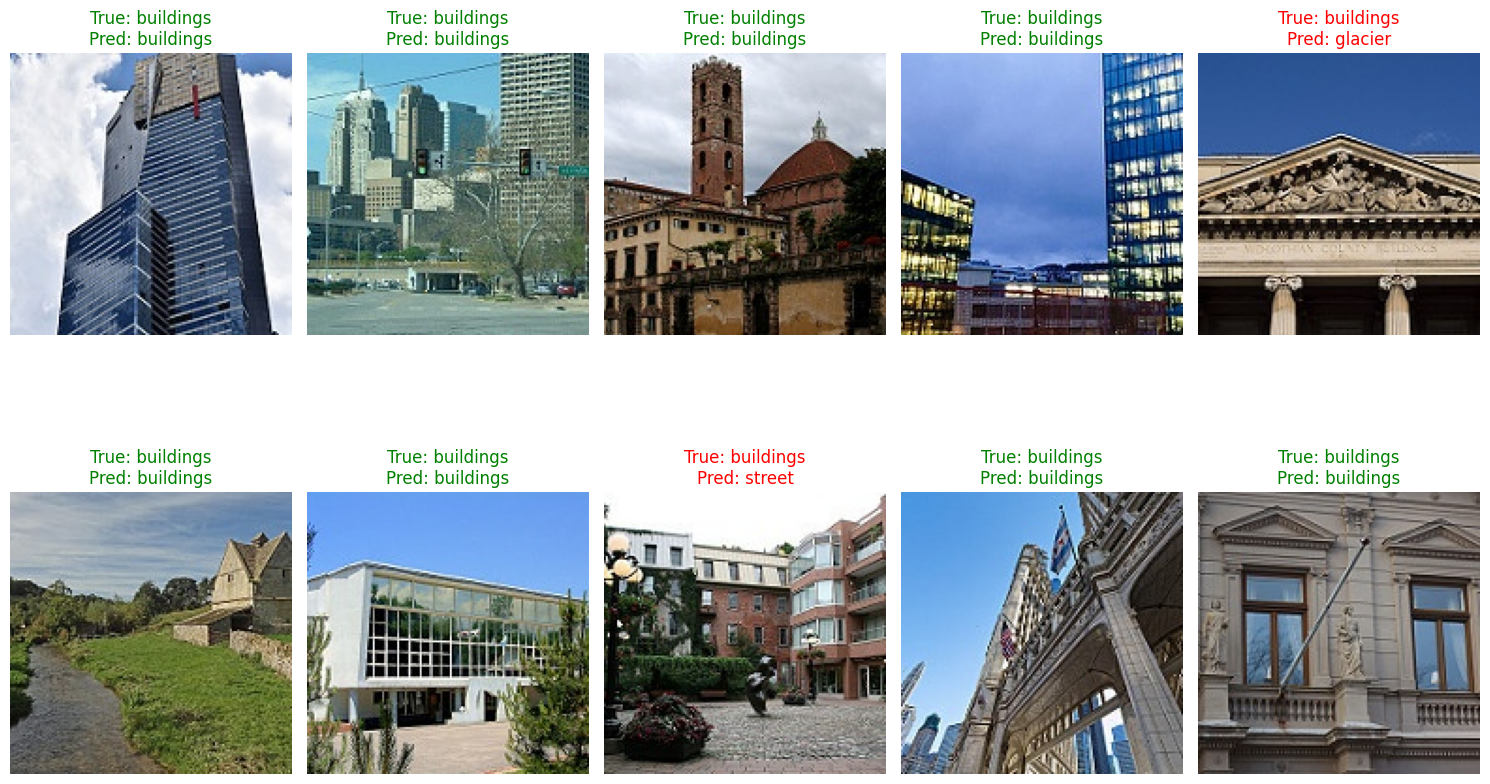

In [18]:
# Step 10: Display Model Predictions
def plot_predictions(model, generator, class_indices):
    class_labels = {v: k for k, v in class_indices.items()}
    images, labels = next(generator)
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels, axis=1)
    plt.figure(figsize=(15, 10))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
        true_label = class_labels[true_classes[i]]
        pred_label = class_labels[predicted_classes[i]]
        plt.title(f"True: {true_label}\nPred: {pred_label}", color='green' if true_label == pred_label else 'red')
    plt.tight_layout()
    plt.show()

plot_predictions(model, test_generator, test_generator.class_indices)